In [1]:
from random import uniform
from collections import namedtuple
import numpy as np

Angles = namedtuple('Angles', ['theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6'])


def get_random_angles() -> Angles:
    return Angles(*[uniform(-np.pi, np.pi) for _ in range(6)])


Constraints = namedtuple('Constraints', ['velocity', 'acceleration'])

# Task 1
Calculate and plot position, velocity, and acceleration trajectories of driving your robot model from configuration $q_0$ to configuration $q_f$ in joint space

In [2]:
initial_position = get_random_angles()
final_position = get_random_angles()
constraints = Constraints(2, 2)

In [3]:
def sign(n: float) -> float:
    if n >= 0:
        return 1
    else:
        return -1

In [4]:
def trapezoidal_trajectory(blend_time: float, non_acceleration_time: float, initial_value: float, final_value: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    _sign = sign(final_value - initial_value)

    first_stage_distance = initial_value + _sign * constraints.acceleration * blend_time ** 2 / 2
    second_stage_distance = first_stage_distance + _sign * constraints.velocity * non_acceleration_time
    timeline = np.linspace(0, blend_time * 2 + non_acceleration_time, 200)

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: initial_value + _sign * constraints.acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + _sign * constraints.velocity * (t - blend_time),
                  lambda t: second_stage_distance + _sign * constraints.velocity * (t - blend_time - non_acceleration_time) - _sign * constraints.acceleration * (t - blend_time - non_acceleration_time) ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: _sign * constraints.acceleration * t,
                  lambda t: _sign * constraints.velocity,
                  lambda t: _sign * constraints.velocity - _sign * constraints.acceleration * (t - blend_time - non_acceleration_time)]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: _sign * constraints.acceleration,
                  lambda t: 0,
                  lambda t: _sign * -constraints.acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [5]:
def triangular_trajectory(initial_value: float, final_value: float):
    _sign = sign(final_value - initial_value)

    blend_time = np.sqrt(abs(final_value - initial_value) / constraints.acceleration)
    timeline = np.linspace(0, blend_time * 2, 200)

    first_stage_distance = initial_value + _sign * constraints.acceleration * blend_time ** 2 / 2

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: initial_value + _sign * constraints.acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + _sign * constraints.acceleration * blend_time * (t - blend_time) - _sign * constraints.acceleration * (t - blend_time) ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: _sign * constraints.acceleration * t,
                  lambda t: _sign * constraints.acceleration * blend_time - _sign * constraints.acceleration * (t - blend_time)]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: _sign * constraints.acceleration,
                  lambda t: _sign * -constraints.acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [6]:
trajectories = []
velocities = []
accelerations = []
timelines = []

for initial, final in zip(initial_position, final_position):
    delta_distance = abs(final - initial)

    blend_time = constraints.velocity / constraints.acceleration
    acceleration_distance = constraints.velocity ** 2 / constraints.acceleration

    non_acceleration_distance = delta_distance - acceleration_distance
    non_acceleration_time = non_acceleration_distance / constraints.velocity

    if non_acceleration_time < 0:
        timeline, trajectory, velocity, acceleration = triangular_trajectory(initial, final)
    else:
        timeline, trajectory, velocity, acceleration = trapezoidal_trajectory(blend_time, non_acceleration_time, initial, final)
    timelines.append(timeline)
    trajectories.append(trajectory)
    velocities.append(velocity)
    accelerations.append(acceleration)

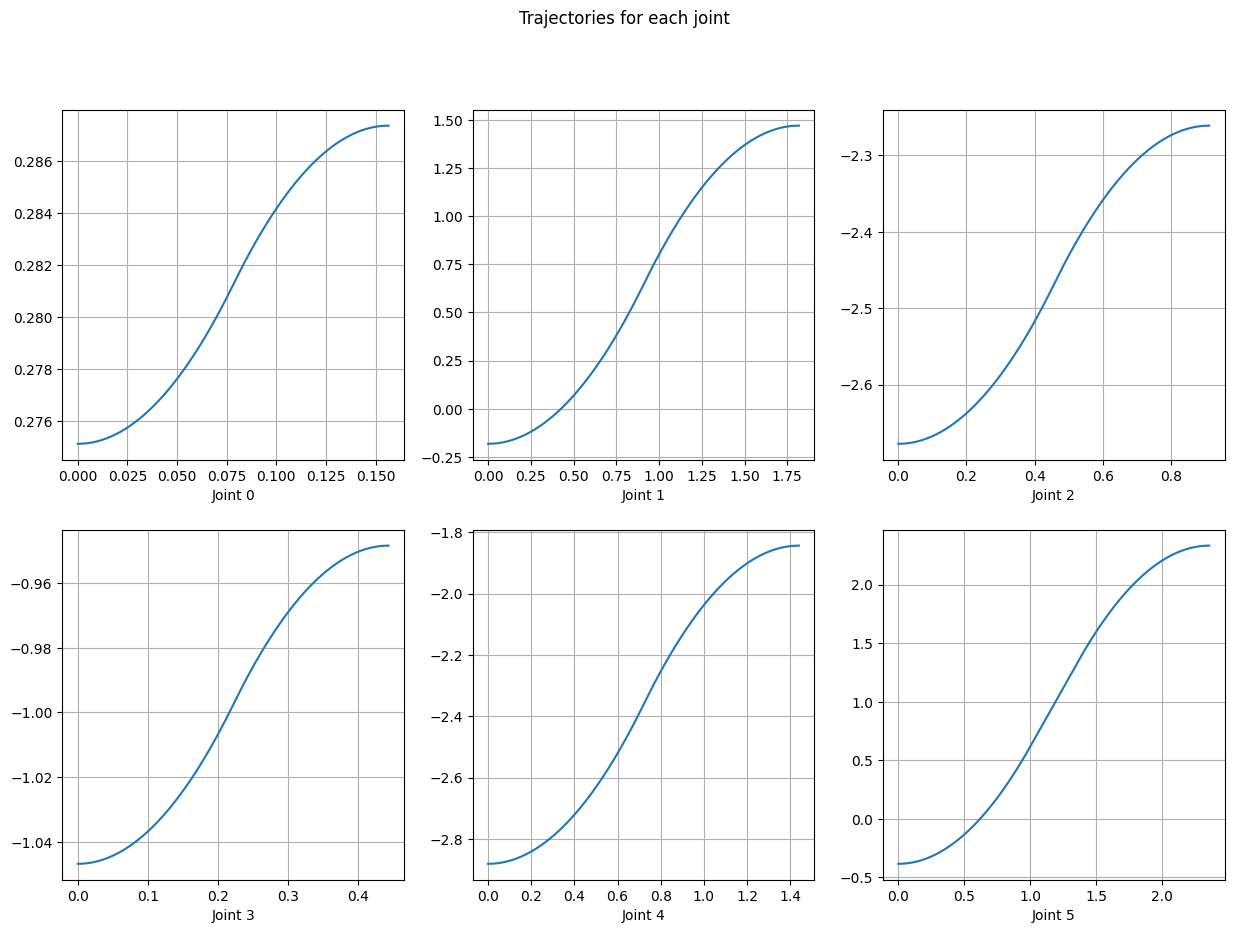

In [7]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Trajectories for each joint')

for i, (timeline, trajectory) in enumerate(zip(timelines, trajectories)):
    axes[i // 3, i % 3].plot(timeline, trajectory)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

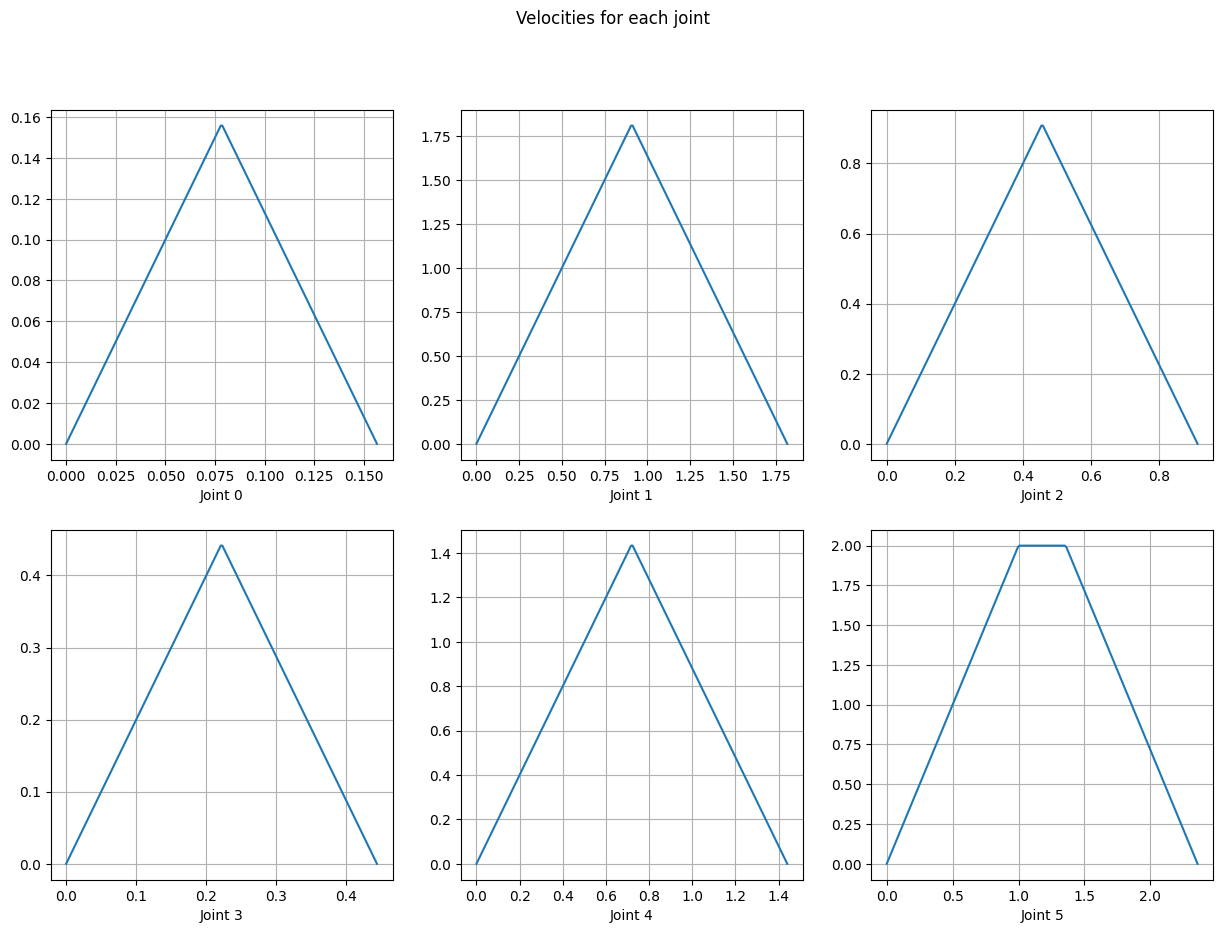

In [8]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Velocities for each joint')

for i, (timeline, velocity) in enumerate(zip(timelines, velocities)):
    axes[i // 3, i % 3].plot(timeline, velocity)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

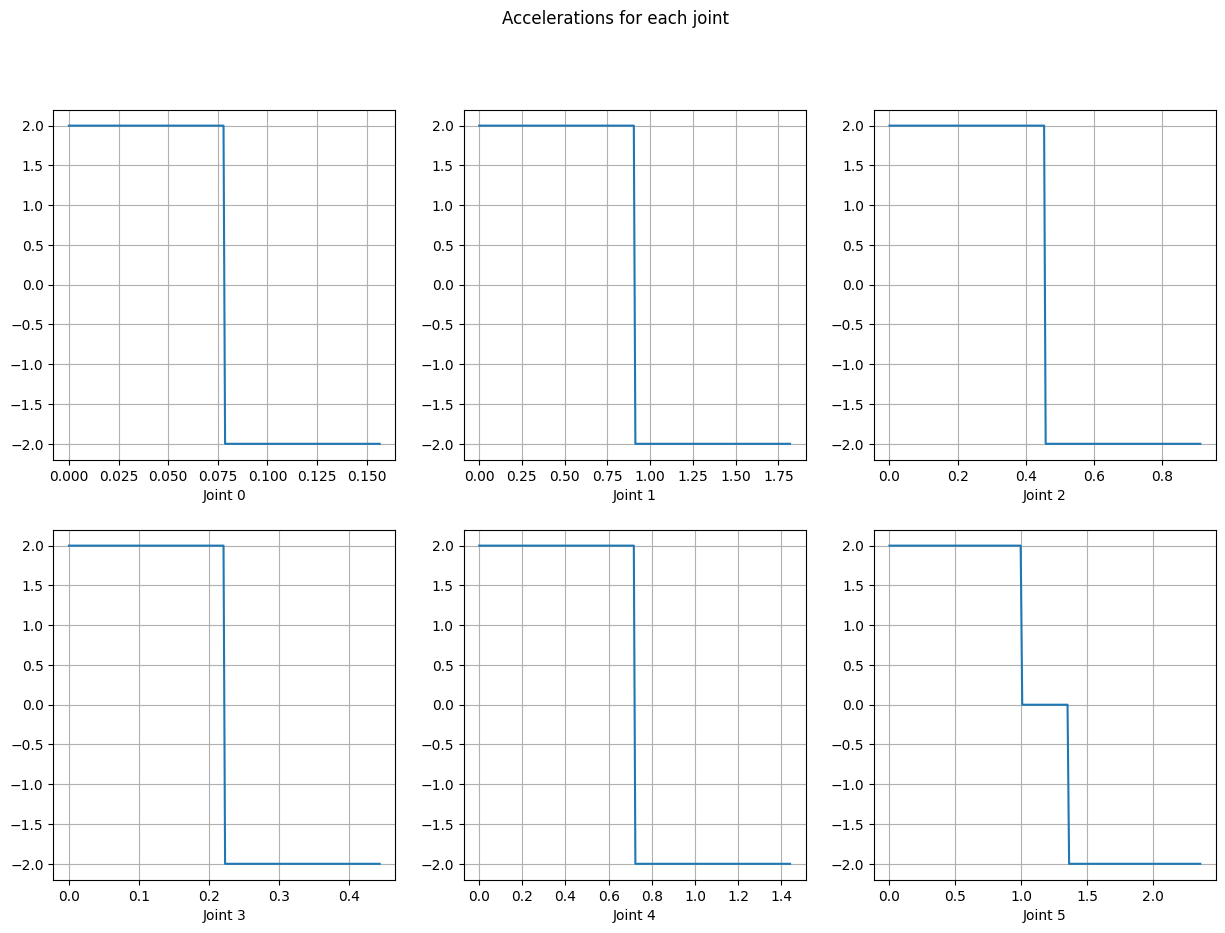

In [9]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Accelerations for each joint')

for i, (timeline, acceleration) in enumerate(zip(timelines, accelerations)):
    axes[i // 3, i % 3].plot(timeline, acceleration)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

# Task 2

Synchronize your 6 joints to start and end motion at the same time.

In [10]:
# calculating maximum blend and non-acceleration times

blend_time = constraints.velocity / constraints.acceleration
acceleration_distance = constraints.velocity ** 2 / constraints.acceleration

max_blend_time = None
max_non_acceleration_time = None

for initial, final in zip(initial_position, final_position):
    delta_distance = abs(final - initial)

    blend_time = constraints.velocity / constraints.acceleration
    acceleration_distance = constraints.velocity ** 2 / constraints.acceleration

    non_acceleration_distance = delta_distance - acceleration_distance
    non_acceleration_time = non_acceleration_distance / constraints.velocity

    if non_acceleration_time < 0:
        blend_time = np.sqrt(abs(final - initial) / constraints.acceleration)
        non_acceleration_time = 0

    if max_blend_time is None or max_blend_time < blend_time:
        max_blend_time = blend_time
    if max_non_acceleration_time is None or max_non_acceleration_time < non_acceleration_time:
        max_non_acceleration_time = non_acceleration_time

In [11]:
# calculating synchronized velocities and accelerations

delta_distances = [final - initial for initial, final in zip(initial_position, final_position)]

synchronized_velocities = [delta / (max_non_acceleration_time + max_blend_time) for delta in delta_distances]
synchronized_accelerations = [velocity / max_blend_time for velocity in synchronized_velocities]

In [12]:
def triangular_synchronized(initial_value: float, blend_time: float, acceleration: float):
    timeline = np.linspace(0, blend_time * 2, 200)

    first_stage_distance = initial_value + acceleration * blend_time ** 2 / 2

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: initial_value + acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + acceleration * blend_time * t - acceleration * t ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: acceleration * t,
                  lambda t: acceleration * blend_time - acceleration * t]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: acceleration,
                  lambda t: -acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [13]:
def trapezoidal_synchronized(initial_value: float, blend_time: float, non_acceleration_time: float, velocity: float, acceleration: float):
    timeline = np.linspace(0, blend_time * 2 + non_acceleration_time, 200)

    first_stage_distance = initial_value + acceleration * blend_time ** 2 / 2
    second_stage_distance = first_stage_distance + velocity * non_acceleration_time

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: initial_value + acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + velocity * (t - blend_time),
                  lambda t: second_stage_distance + velocity * (t - blend_time - non_acceleration_time) - acceleration * (t - blend_time - non_acceleration_time) ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: acceleration * t,
                  lambda t: velocity,
                  lambda t: velocity - acceleration * (t - blend_time - non_acceleration_time)]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: acceleration,
                  lambda t: 0,
                  lambda t: -acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [14]:
# calculating synchronized trajectories

trajectories = []
velocities = []
accelerations = []
timelines = []

for initial, final, velocity, acceleration in zip(initial_position, final_position, synchronized_velocities, synchronized_accelerations):
    delta_distance = abs(final - initial)

    acceleration_distance = velocity ** 2 / acceleration
    non_acceleration_distance = delta_distance - acceleration_distance

    if non_acceleration_distance < 0:
        timeline, trajectory, velocity, acceleration = triangular_synchronized(initial, blend_time, acceleration)
    else:
        timeline, trajectory, velocity, acceleration = trapezoidal_synchronized(initial, blend_time, non_acceleration_time, velocity, acceleration)
    timelines.append(timeline)
    trajectories.append(trajectory)
    velocities.append(velocity)
    accelerations.append(acceleration)

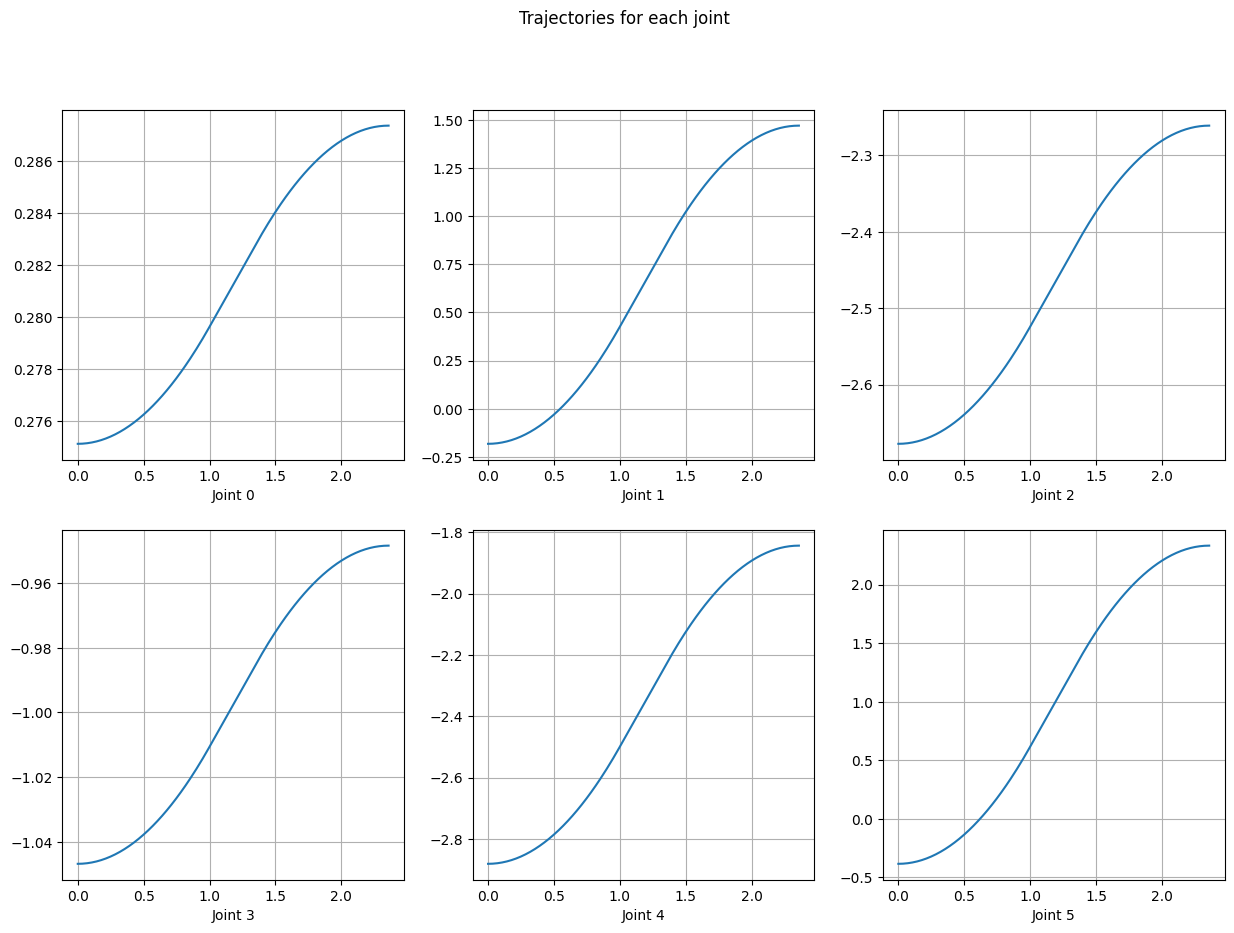

In [16]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Trajectories for each joint')

for i, (timeline, trajectory) in enumerate(zip(timelines, trajectories)):
    axes[i // 3, i % 3].plot(timeline, trajectory)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

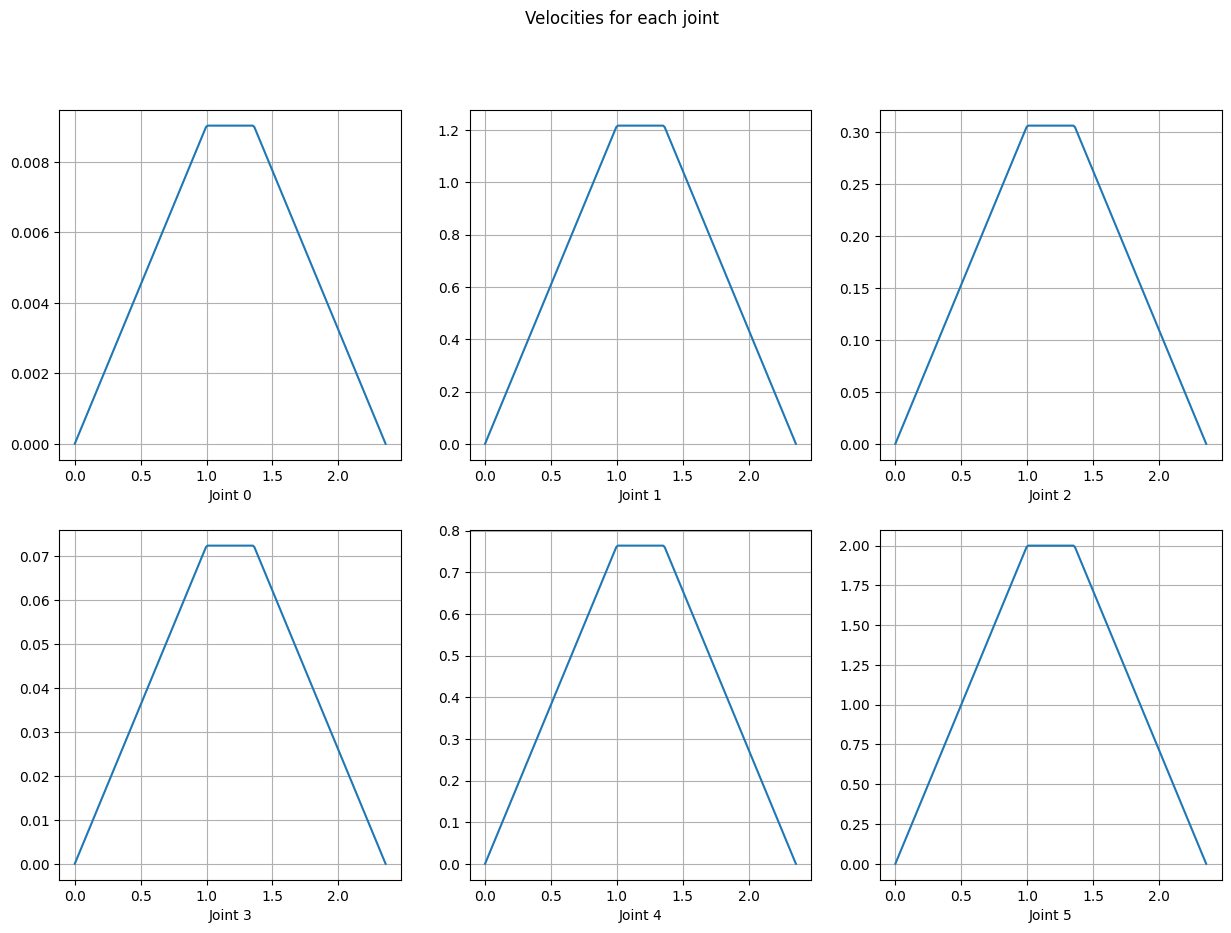

In [17]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Velocities for each joint')

for i, (timeline, velocity) in enumerate(zip(timelines, velocities)):
    axes[i // 3, i % 3].plot(timeline, velocity)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

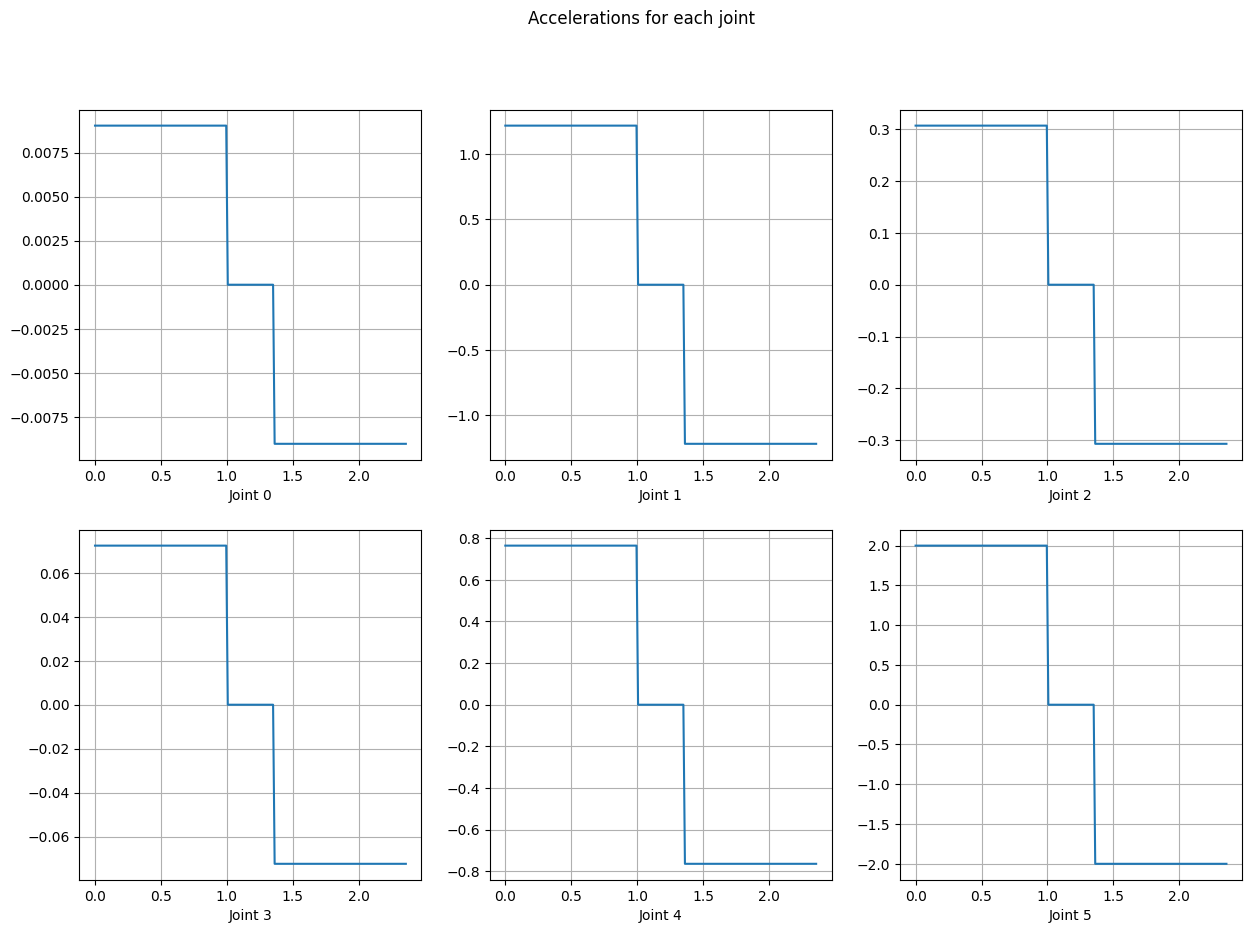

In [18]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Accelerations for each joint')

for i, (timeline, acceleration) in enumerate(zip(timelines, accelerations)):
    axes[i // 3, i % 3].plot(timeline, acceleration)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

# Task 3

Consider you have controller frequency of 20Hz.